# SmoothGrad : removing noise by adding noise

The motivation behind **SmoothGrad** is basically because the methods in the last two papers, i.e., **Vanilla Gradient** and **Integrated Gradients**, produce **noisy outputs** even though they capture useful information. This noise arises due to the **sharp fluctuations in gradients**, which occur naturally in deep neural networks, especially those using **ReLU activations**.

SmoothGrad is a **pretty simple but powerful** concept of **adding Gaussian noise** to the input image and then **averaging over the gradients**. This approach helps in **filtering out random noise while preserving truly important features**, creating a **sharper sensitivity map**.

The formula for **SmoothGrad** is:

$$
M_c^{\text{SmoothGrad}}(x) = \frac{1}{n} \sum_{i=1}^{n} M_c(x + N(0, \sigma^2))
$$

where:

- \( M_c(x) \) represents the **saliency map** for class \( c \).
- \( x \) is the **input image**.
- \( N(0, \sigma^2) \) is **Gaussian noise** with mean **0** and standard deviation \( \sigma \).
- \( n \) is the **number of noise samples** used for averaging.


---

## **How SmoothGrad Works**
So, it's simple! Let's just look at an image’s two important things:

### **1. The Robust Features **
- Even if we **add small noise**, these features **consistently contribute** to the model's prediction.  

### **2. The Noisy Features **
- They may have **high attributions**, even though they **don’t globally contribute** to the real classification.Each time we **add noise**, high attributions appear at **different locations**, or sometimes they **don’t appear at all**.  By **averaging them**, they cancel out, leading to a **much more efficient saliency map**.


###  Future works : 
- Since IG captures global attributions and SmoothGrad enhances local details but may over-smooth global features, combining them can create a hybrid method that preserves both. IG ensures accurate feature importance, while SmoothGrad removes noise and sharpens details, leading to a clearer and more balanced attribution map.
- Now we are giving a fixed Noise y cant we give adaptive noise based on regions.
- Now we are using fixed hyperparamters for the noise level and number of samples as mentioned in the paper , y cant we use NN or some leaning techniques to learn the optimal smoothing startegies and get the best parameters.

---

Predicted class for C:\Users\VISHNU\Downloads\soccer.jpg: 805


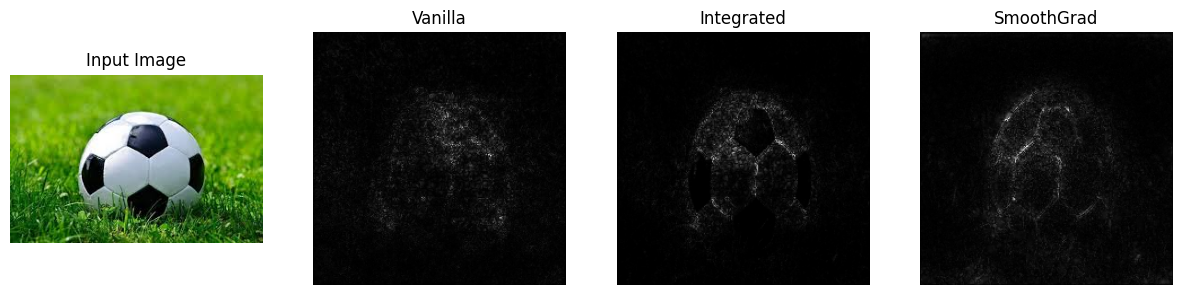

Predicted class for C:\Users\VISHNU\Downloads\pexels-bertellifotografia-1906153.jpg: 132


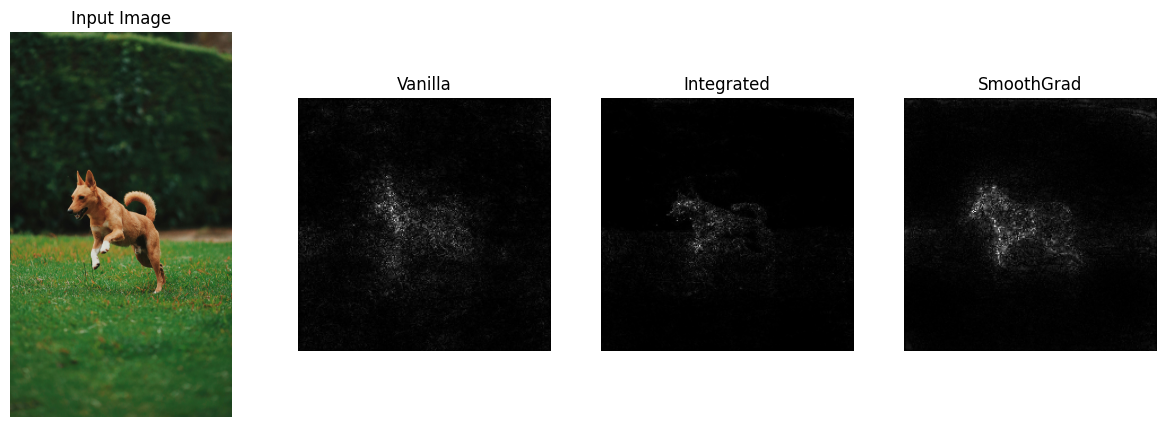

In [3]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from torchvision.models import vgg19
import matplotlib.pyplot as plt

# Custom Integrated Gradients Implementation
def integrated_gradients(model, input_image, target_index, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(input_image)
    
    scaled_inputs = [baseline + (float(i) / steps) * (input_image - baseline) for i in range(steps + 1)]
    
    gradients = []
    
    # Loop through scaled inputs and compute gradients
    for scaled_input in scaled_inputs:
        scaled_input = scaled_input.requires_grad_()  # Ensure it requires gradients
        scaled_input.retain_grad()  # Ensure gradients are retained
        output = model(scaled_input)
        model.zero_grad()
        
        # Only perform backward pass if there is a valid target index
        if output is not None:
            output[0, target_index].backward(retain_graph=True)  # Use retain_graph if you want to keep the computational graph
            gradients.append(scaled_input.grad.clone())  # Append the gradient
        
    avg_gradients = torch.mean(torch.stack(gradients), dim=0)
    integrated_grads = (input_image - baseline) * avg_gradients
    
    return integrated_grads

# Custom SmoothGrad Implementation
def smoothgrad(model, input_image, target_index, n_samples=50, sigma=0.2):
    gradients = []
    for _ in range(n_samples):
        noise = torch.randn_like(input_image) * sigma
        noisy_input = input_image + noise
        noisy_input = noisy_input.requires_grad_()
        noisy_input.retain_grad()  # Ensure gradients are retained
        output = model(noisy_input)
        model.zero_grad()
        output[0, target_index].backward()
        gradients.append(noisy_input.grad.clone())
    avg_gradients = torch.mean(torch.stack(gradients), dim=0)
    return avg_gradients

def preprocess_image(image_path):
    img = cv2.imread(image_path, 1)
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    img = torch.tensor(img.transpose(2, 0, 1)).unsqueeze(0)
    return img.requires_grad_()

def save_as_gray_image(tensor):
    # Aggregate across color channels and normalize
    img = tensor.abs().sum(dim=1, keepdim=True)
    img = img - img.min()
    img = img / img.max()
    img = img.squeeze().detach().numpy()
    return img

def display_images(input_image, images, titles):
    fig, axes = plt.subplots(1, len(images) + 1, figsize=(15, 5))
    # Display input image
    axes[0].imshow(cv2.cvtColor(cv2.imread(input_image), cv2.COLOR_BGR2RGB))
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    # Display other images
    for ax, img, title in zip(axes[1:], images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.show()

def process_image(image_path, model):
    input_image = preprocess_image(image_path)
    output = model(input_image)
    target_index = output.argmax().item()
    print(f'Predicted class for {image_path}: {target_index}')

    # Compute Vanilla Gradient
    input_image.requires_grad_()
    output = model(input_image)
    model.zero_grad()
    output[0, target_index].backward()
    vanilla_grad = input_image.grad.clone()
    vanilla_grad_img = save_as_gray_image(vanilla_grad)

    # Compute Integrated Gradients
    ig_grad = integrated_gradients(model, input_image, target_index)
    ig_grad_img = save_as_gray_image(ig_grad)

    # Compute SmoothGrad
    sg_grad = smoothgrad(model, input_image, target_index)
    sg_grad_img = save_as_gray_image(sg_grad)

    return vanilla_grad_img, ig_grad_img, sg_grad_img

def main(image_paths):
    model = vgg19(pretrained=True).eval()
    
    for image_path in image_paths:
        vanilla_grad_img, ig_grad_img, sg_grad_img = process_image(image_path, model)
        images = [vanilla_grad_img, ig_grad_img, sg_grad_img]
        titles = ['Vanilla', 'Integrated', 'SmoothGrad']
        display_images(image_path, images, titles)

if __name__ == '__main__':
    image_paths = [
        "C:\\Users\\VISHNU\\Downloads\\soccer.jpg",
        "C:\\Users\\VISHNU\\Downloads\\pexels-bertellifotografia-1906153.jpg"
    ]
    main(image_paths)

## Integrated-Gradient + SmoothGrad

#### Positives of Integrated Gradients : 
- IG captures mathematically logical feature attributions as they follow the axioms and that can be a good reason why it can used to explain AI.
- It is computationally not that heavy as combining it with smoothgrad which is computational heavier maynot that feasible  

####  Positives of SmoothGrad:
- SmoothGrad cancel outs noise and sharpens important feature by averaging.


## Algorithm of smoothgrad_integrated_gradients
- Generate Noisy input Variations 
- Compute IG for Each noisy input using our previous paper method
- Average across all the noisy IG maps 
- Return and visalize the final IG + Smooth Grad vizualization map


The only disadvantage is that its computationally bit heavier 

Predicted class for C:\Users\VISHNU\Downloads\soccer.jpg: 805


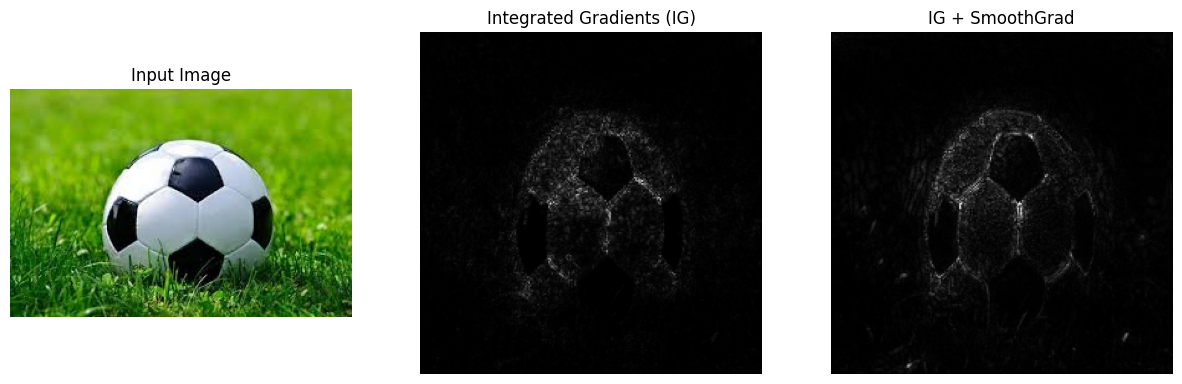

Predicted class for C:\Users\VISHNU\Downloads\pexels-bertellifotografia-1906153.jpg: 132


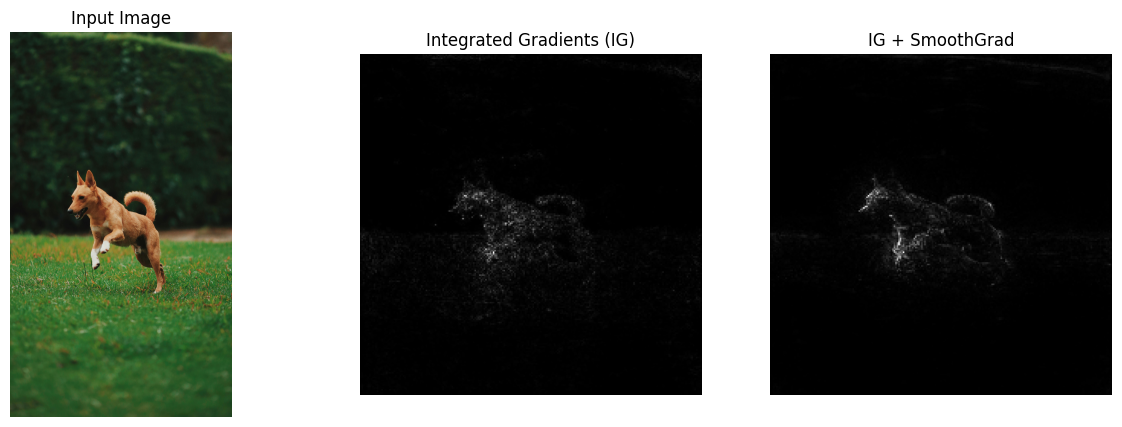

In [5]:
import torch
import torch.nn as nn
from torchvision.models import vgg19, VGG19_Weights
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Integrated Gradients (IG) Implementation
def integrated_gradients(model, input_image, target_index, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(input_image)
    
    scaled_inputs = [baseline + (float(i) / steps) * (input_image - baseline) for i in range(steps + 1)]
    
    gradients = []
    for scaled_input in scaled_inputs:
        scaled_input = scaled_input.clone().detach().requires_grad_(True)  # ✅ Ensure gradient tracking
        output = model(scaled_input)
        model.zero_grad()
        output[0, target_index].backward(retain_graph=True)
        
        if scaled_input.grad is not None:  # ✅ Ensure gradient exists before appending
            gradients.append(scaled_input.grad.clone()) 
        else:
            print("Warning: Gradient is None. Check if input requires gradients.")
    
    avg_gradients = torch.mean(torch.stack(gradients), dim=0)
    integrated_grads = (input_image - baseline) * avg_gradients
    
    return integrated_grads

# SmoothGrad applied to Integrated Gradients
def smoothgrad_integrated_gradients(model, input_image, target_index, n_samples=50, sigma=0.2, steps=50):
    gradients = []
    for _ in range(n_samples):
        noise = torch.randn_like(input_image) * sigma
        noisy_input = (input_image + noise).clone().detach().requires_grad_(True)  # ✅ Ensure gradient tracking
        noisy_ig = integrated_gradients(model, noisy_input, target_index, steps=steps)
        gradients.append(noisy_ig)
    
    smooth_ig = torch.mean(torch.stack(gradients), dim=0)
    return smooth_ig

# Preprocess image
def preprocess_image(image_path):
    img = cv2.imread(image_path, 1)
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    img = torch.tensor(img.transpose(2, 0, 1)).unsqueeze(0)
    return img.clone().detach().requires_grad_(True)  # ✅ Ensure input requires gradients

# Save and normalize image
def save_as_gray_image(tensor):
    img = tensor.abs().sum(dim=1, keepdim=True)
    img = img - img.min()
    img = img / img.max()
    img = img.squeeze().detach().numpy()
    return img

# Process Image with IG and IG + SmoothGrad
def process_image(image_path, model):
    input_image = preprocess_image(image_path)
    output = model(input_image)
    target_index = output.argmax().item()
    print(f'Predicted class for {image_path}: {target_index}')

    # Compute Integrated Gradients
    ig_grad = integrated_gradients(model, input_image, target_index)
    ig_grad_img = save_as_gray_image(ig_grad)

    # Compute SmoothGrad Integrated Gradients
    smooth_ig_grad = smoothgrad_integrated_gradients(model, input_image, target_index)
    smooth_ig_grad_img = save_as_gray_image(smooth_ig_grad)

    return ig_grad_img, smooth_ig_grad_img

# Display side-by-side comparison
def display_comparison(input_image, ig_img, smooth_ig_img):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display Original Image
    axes[0].imshow(cv2.cvtColor(cv2.imread(input_image), cv2.COLOR_BGR2RGB))
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    # Display IG
    axes[1].imshow(ig_img, cmap='gray')
    axes[1].set_title('Integrated Gradients (IG)')
    axes[1].axis('off')

    # Display IG + SmoothGrad
    axes[2].imshow(smooth_ig_img, cmap='gray')
    axes[2].set_title('IG + SmoothGrad')
    axes[2].axis('off')

    plt.show()

# Main Function
def main(image_paths):
    model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).eval()  # ✅ Updated to avoid deprecated 'pretrained' warning
    
    for image_path in image_paths:
        ig_img, smooth_ig_img = process_image(image_path, model)
        display_comparison(image_path, ig_img, smooth_ig_img)

if __name__ == '__main__':
    image_paths = [
        "C:\\Users\\VISHNU\\Downloads\\soccer.jpg",
        "C:\\Users\\VISHNU\\Downloads\\pexels-bertellifotografia-1906153.jpg"
    ]
    main(image_paths)
